In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fn="../prices.txt"
df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
prices = (df.values).T

nInst ,T = 50,750

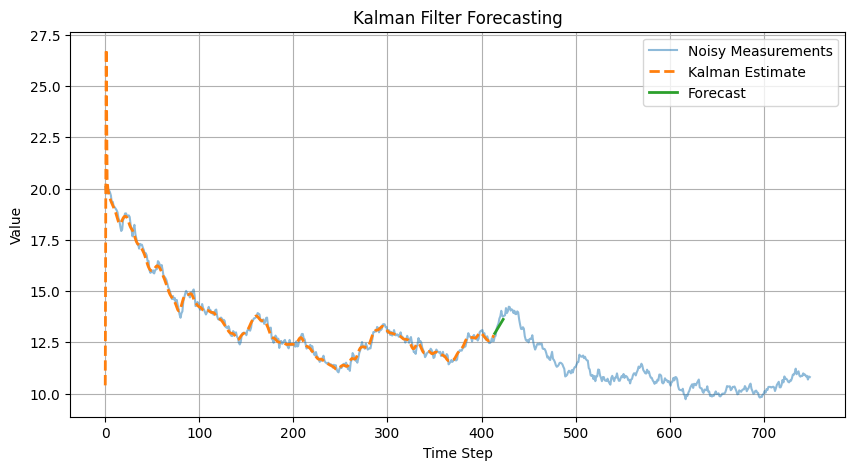

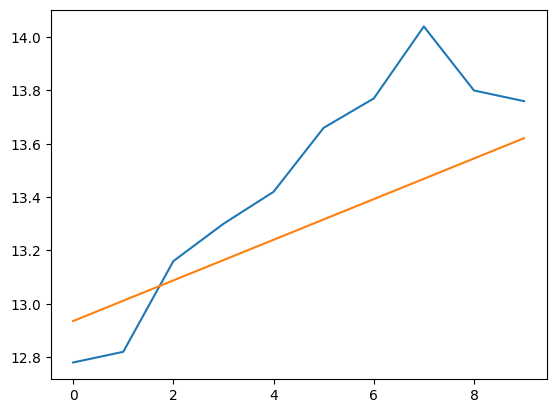

12.859170695219643 0.07619665774386154


In [ ]:
# Simulate a 1D system: constant velocity + noise

instID = 33
instPrice = prices[instID]


stop = 420
measurements = instPrice[:stop]
kern = [0.5,1,2,3,2,1,0.5]
measurements = np.convolve(measurements,kern,mode="valid")/sum(kern)

# Kalman filter setup
x = 0.0           # initial estimate
v = 0.5           # initial velocity
P = 1.0           # initial uncertainty
Q = 0.05         # process noise (model uncertainty)
R = 1.0           # measurement noise
A = 1.0           # state transition (no change to state, just incremented by v)
H = 1.0           # measurement matrix
x_estimates = []

for z in measurements:
    # Predict step
    x = x + v               # predict next state
    P = P + Q               # update uncertainty

    # Update step
    v = P * (z-x)
    K = P / (P + R)         # Kalman gain
    x = x + K * (z - x)     # update estimate
    P = (1 - K) * P         # update uncertainty

    x_estimates.append(x)

# Forecast future steps
n = len(measurements)
future_steps = 10
forecast = [x + v * i for i in range(1, future_steps + 1)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(instPrice, label='Noisy Measurements', alpha=0.5)
plt.plot(x_estimates, label='Kalman Estimate', linewidth=2)
plt.plot(np.arange(n, n+future_steps), forecast, label='Forecast', linewidth=2)
plt.legend()
plt.title("Kalman Filter Forecasting")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()


plt.plot(instPrice[n:n+future_steps],label="true")
plt.plot(forecast,lebel="forecast")
plt.show()

print(x,v,)